# Predicting Player's Data Contibutions Based on their Experience #

*Skye Fort, Lauren Friesen, Taylor Jackson & Sam Thompson*

## Introduction ##
Minecraft, a game of blocks, building, and exploration developed in Java, has captivated millions worldwide. Over the years, its interactive nature has made it a platform of growing interest for research, particularly with advancements in AI. UBC PLAI Lab attempts to train a generative Ai model using audio recording of multiplayer minecraft. This project aims to create accurate predictive tools for targeted demographic research.

The central question is: How effectively can self-reported experience and age predict a player's contribution to the study, as measured by playtime hours? To address this, we will utilize the Plaicraft dataset, which provides detailed player data, including exact playtime, age, self-reported experience, and derived metrics like total sessions played.

By analyzing these variables, this project seeks to identify the most significant factors and relationships that define key player demographics. The ultimate goal is to help researchers pinpoint and engage suitable participants for future studies effectively.


## Methods ##

In [21]:
#Load R library packages to access all necessary functions

library(tidyverse)
library(repr)
library(rvest)
library(tidymodels)
library(dplyr)
library(ggplot2)

In [19]:
#read data from url
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

players_data<-read_csv(players_url)
head(players_data)

sessions_data<-read_csv(sessions_url)
head(sessions_data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [44]:
contribution <- players_data |>
    select(experience, played_hours, age)
head(contribution)

experience,played_hours,age
<chr>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
Amateur,0.7,21
Regular,0.1,21
Amateur,0.0,17


In [45]:
set.seed(2000)

contribution_split <- initial_split(contribution, prop = 0.6, strata = played_hours) 

contribution_training <- training(contribution_split)
contribution_testing <- testing(contribution_split) 

In [51]:
contribution_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("regression") 

contribution_recipe <- recipe(played_hours ~ age + experience, data = contribution_training)
       
contribution_recipe 



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



In [47]:
contribution_vfold <- vfold_cv(contribution_training, v = 5, strata = played_hours) 

contribution_workflow <- workflow() |>
                    add_recipe(contribution_recipe) |>
                    add_model(contribution_spec) |>
                    fit(data = contribution_training)
contribution_workflow

Warning message:
“tune samples were requested but there were 116 rows in the data. 111 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 5.630623
Minimal mean squared error: 320.7318
Best kernel: rectangular
Best k: 111

In [48]:
gridvals <- tibble(neighbors = seq(from = 1, to = 86, by = 10)) 

contribution_results <- contribution_workflow |>
                    tune_grid(resamples = contribution_vfold, grid = gridvals) |>
    collect_metrics()
contribution_results

contribution_min <- contribution_results |>
    filter(.metric == "rmse") |>
    arrange(mean) |>
    slice (1)
contribution_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,19.443413206,5,8.019895256,Preprocessor1_Model1
1,rsq,standard,0.034219295,5,0.027075241,Preprocessor1_Model1
11,rmse,standard,15.439594423,5,5.986557976,Preprocessor1_Model2
11,rsq,standard,0.039597525,5,0.018421892,Preprocessor1_Model2
21,rmse,standard,13.821957341,5,6.333632573,Preprocessor1_Model3
21,rsq,standard,0.029699943,5,0.013860727,Preprocessor1_Model3
31,rmse,standard,13.456814023,5,6.441806980,Preprocessor1_Model4
31,rsq,standard,0.027127860,5,0.014058439,Preprocessor1_Model4
41,rmse,standard,13.375724923,5,6.487553275,Preprocessor1_Model5


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,rmse,standard,13.37572,5,6.487553,Preprocessor1_Model5


In [49]:
contribution_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 71) |>
          set_engine("kknn") |>
          set_mode("regression")

contribution_best_fit <- workflow() |>
          add_recipe(contribution_recipe) |>
          add_model(contribution_best_spec) |>
          fit(data = contribution_training)

contribution_summary <- contribution_best_fit |>
           predict(contribution_testing) |>
           bind_cols(contribution_testing) |>
           metrics(truth = played_hours, estimate = .pred)

contribution_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.880885e+01
rsq,standard,7.286053e-04
mae,standard,1.171947e+01


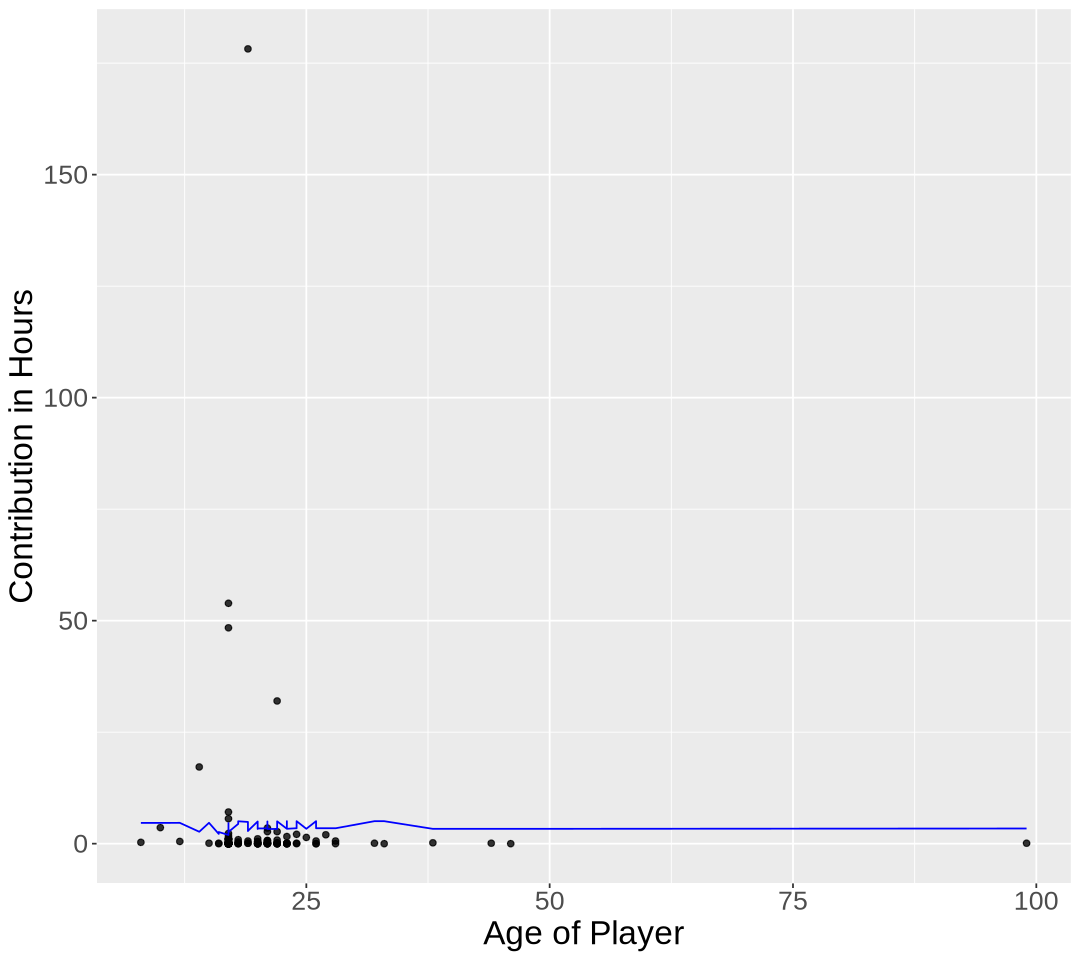

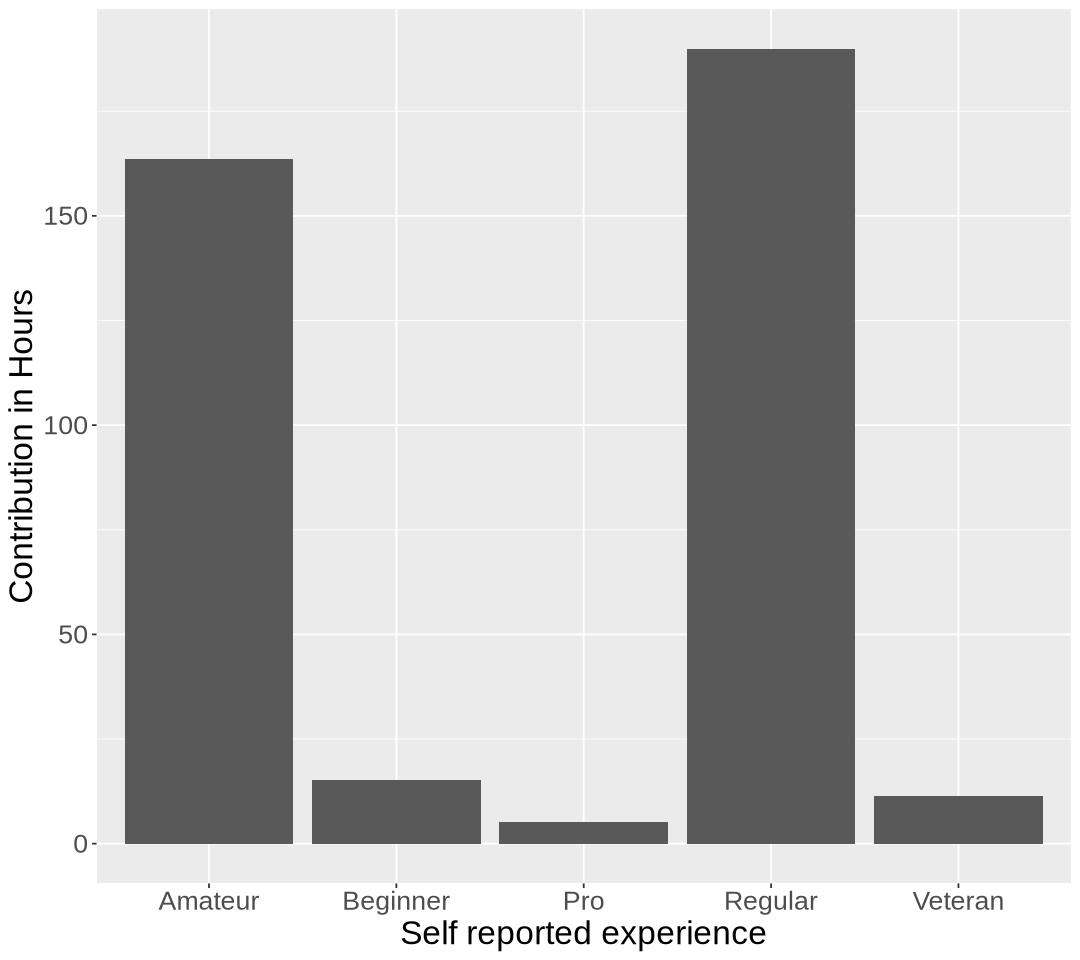

In [50]:
contribution_preds <- contribution_best_fit |>
        predict(contribution_training) |>
        bind_cols(contribution_training) 

contribution_plot <- ggplot(contribution_preds, aes(x = age, y = played_hours)) +
        geom_point(alpha = 0.8) +
        xlab("Age of Player") +
        ylab("Contribution in Hours") +
        geom_line(data = contribution_preds, aes(x = age, y = .pred), color = "blue") +
        theme(text = element_text(size = 20))
contribution_plot

contribution_plot_2 <- ggplot(contribution_preds, aes(x = experience, y = played_hours)) +
        geom_bar(stat="identity") +
        xlab("Self reported experience") +
        ylab("Contribution in Hours") +
        theme(text = element_text(size = 20))
contribution_plot_2